## Learning-to-rank using the WARP loss

- Tutorial: http://lyst.github.io/lightfm/docs/examples/warp_loss.html
- dataset: https://grouplens.org/datasets/movielens/100k/

LightFM is probably the only recommender package implementing the WARP (Weighted Approximate-Rank Pairwise) loss for implicit feedback learning-to-rank. Generally, it perfoms better than the more popular BPR (Bayesian Personalised Ranking) loss — often by a large margin. 

WARP deals with (user, positive item, negative item) triplets. Unlike BPR, the negative items in the triplet are not chosen by random sampling: they are chosen from among those negatie items which would violate the desired item ranking given the state of the model. This approximates a form of active learning where the model selects those triplets that it cannot currently rank correctly.

- BPR: Bayesian Personalised Ranking pairwise loss: It maximizes the prediction difference between 
	a positive example and a randomly chosen negative example. It is useful when only positive interactions are present.

- WARP: Weighted Approximate-Rank Pairwise loss: Maximises the rank of positive examples 
	by repeatedly sampling negative examples until rank violating one is found

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import auc_score

/anaconda3/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


### BRP vs WARP

In [2]:
movielens = fetch_movielens()

In [3]:
train, test = movielens['train'], movielens['test']

In [4]:
alpha = 1e-05
epochs = 70
num_components = 32

In [5]:
warp_model = LightFM(no_components=num_components,
                    loss='warp',
                    learning_schedule='adagrad',
                    max_sampled=100,
                    user_alpha=alpha,
                    item_alpha=alpha)

bpr_model = LightFM(no_components=num_components,
                    loss='bpr',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

In [6]:
warp_auc = []
bpr_auc = []

In [7]:
for epoch in range(epochs):
    warp_model.fit_partial(train, epochs=1)
    warp_auc.append(auc_score(warp_model, test, train_interactions=train).mean())

for epoch in range(epochs):
    bpr_model.fit_partial(train, epochs=1)
    bpr_auc.append(auc_score(bpr_model, test, train_interactions=train).mean())

In [8]:
np.array(warp_auc).mean()

0.93195987

In [9]:
np.array(bpr_auc).mean()

0.88423866

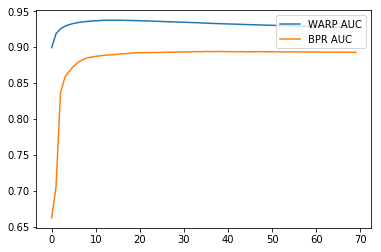

In [10]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.plot(x, np.array(bpr_auc))
plt.legend(['WARP AUC', 'BPR AUC'], loc='upper right')
plt.show()

### Build a simple rec model with WARP
- https://towardsdatascience.com/how-to-build-a-movie-recommender-system-in-python-using-lightfm-8fa49d7cbe3b


In [1]:
# data prep
data = fetch_movielens(min_rating = 4.0)

NameError: name 'fetch_movielens' is not defined

In [12]:
print(repr(data['train']))
print(repr(data['test']))

<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 49906 stored elements in COOrdinate format>
<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 5469 stored elements in COOrdinate format>


In [13]:
warp_model.fit(data['train'], epochs=30, num_threads=2)

In [14]:
def simple_recommendation(model, data, user_ids):

    n_users, n_items = data['train'].shape

    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        scores = model.predict(user_id, np.arange(n_items))
        top_items = data['item_labels'][np.argsort(-scores)]

        print("User %s" % user_id)
        print("Known positives:")
        
        for x in known_positives[:10]:
            print("  %s" % x)

        print("Recommended:")

        for x in top_items[:10]:
            print("  %s" % x)

In [15]:
simple_recommendation(warp_model, data, [3])

User 3
Known positives:
  Seven (Se7en) (1995)
  Contact (1997)
  Starship Troopers (1997)
  Air Force One (1997)
  In & Out (1997)
  Lost Highway (1997)
  Cop Land (1997)
  Desperate Measures (1998)
  Assignment, The (1997)
  Wonderland (1997)
Recommended:
  Starship Troopers (1997)
  Cop Land (1997)
  Chasing Amy (1997)
  Air Force One (1997)
  Scream (1996)
  L.A. Confidential (1997)
  I Know What You Did Last Summer (1997)
  Game, The (1997)
  Contact (1997)
  Kiss the Girls (1997)


In [16]:
pd.Series(data['item_labels'][data['test'].tocsr()[3].indices])

0                          Star Wars (1977)
1                      Event Horizon (1997)
2                             Scream (1996)
3                          Liar Liar (1997)
4                        Ulee's Gold (1997)
5                Wedding Singer, The (1998)
6    One Flew Over the Cuckoo's Nest (1975)
7                          Incognito (1997)
dtype: object

In [17]:
simple_recommendation(warp_model, data, [77])

User 77
Known positives:
  Welcome to the Dollhouse (1995)
  Jerry Maguire (1996)
  Scream (1996)
  Nutty Professor, The (1996)
  Soul Food (1997)
Recommended:
  Scream (1996)
  Jerry Maguire (1996)
  Fargo (1996)
  Welcome to the Dollhouse (1995)
  Trainspotting (1996)
  People vs. Larry Flynt, The (1996)
  Dead Man Walking (1995)
  Twelve Monkeys (1995)
  Nutty Professor, The (1996)
  Leaving Las Vegas (1995)


In [18]:
pd.Series(data['item_labels'][data['test'].tocsr()[77].indices])

0     My Best Friend's Wedding (1997)
1                 Men in Black (1997)
2                        Evita (1996)
3                     In & Out (1997)
4         Very Brady Sequel, A (1996)
5    Love! Valour! Compassion! (1997)
dtype: object

### 배민/배라 order data

In [3]:
tf = pd.read_csv("rec_shop_menu.csv")

In [4]:
tf.shape

(1000000, 4)

In [5]:
tf.head()

,dvc_id,shop_no,food_nm,ord_food_price
0,OPUDa12c16790e836d90,10791293,치파오치킨,9000
1,OPUDa12c16790e836d90,10847381,짜장면,6000
2,OPUDa12c16790e836d90,10847381,간짜장,7000
3,OPUD8bb8bdb8198af902,10740817,참치 김치찌개 2인세트,22500
4,OPUD8bb8bdb8198af902,10793530,스테이크 덮밥,14800


In [6]:
tf.tail()

,dvc_id,shop_no,food_nm,ord_food_price
999995,OPUD4B993AD4-05C4-4026-BCBC-A7042BFB8623,10566844,물밀면,6500
999996,OPUD1398563D-D326-470D-9493-C10FA832B575,10777688,고르곤졸라씬피자,14900
999997,OPUD1398563D-D326-470D-9493-C10FA832B575,10777688,봉골레파스타,14900
999998,OPUD1398563D-D326-470D-9493-C10FA832B575,10729037,간큰갈비세트,23000
999999,OPUD1398563D-D326-470D-9493-C10FA832B575,10714808,딸기티라미수,12500


In [17]:
tf.dvc_id.value_counts()[:20]

OPUDe9f0c5fcb131177d                        649
OPUDa99cd8625e34752f                        585
OPUD5D0100DB-938D-4A76-A42E-DBD14E8ED612    477
OPUDd5e75d82e0939053                        333
OPUD1B5BE0DB-9919-4D83-BAEB-F96E7045236C    331
OPUD8ECD5A5D-3130-49A3-B6F5-ADBA5BFEDBD9    289
OPUD889AEAC8-39A8-4884-A118-E092E6A7BE1C    184
OPUD9EB144EB-B34D-4C07-8A34-4A9F1A2ED07F    179
OPUD2A81C94A-752B-4751-8E9D-962141A9A234    166
OPUDBFBAED42-267C-4AEC-848C-06A9ECF42FD6    163
OPUD0941F264-8DD4-419E-9706-35301D11288E    158
OPUDbb54a21912dfe6b5                        151
OPUD18eea3f41dce50cc                        151
OPUDf1fdb39b07b57b2                         146
OPUD84D659EE-8041-40CE-B9B2-84C7D06608C1    146
OPUD5a19651becc8bf36                        143
OPUDAB8F0C97-EAB8-4730-91FD-5C1B73DE1897    137
OPUDD28DDE81-93D4-44C5-8E2B-1CDB7EDD7B5A    133
OPUDD707C776-E2A3-4ACE-9641-3299962FE164    129
OPUDcb995d4ec9b589f4                        129
Name: dvc_id, dtype: int64

In [8]:
tf.food_nm.value_counts()[:20]

볶음밥          7188
짬뽕           6941
간짜장          6408
불고기버거세트      4906
새우버거세트       4869
탕수육          4453
교촌 허니 콤보     3846
제육덮밥         3699
후라이드치킨       3601
김치볶음밥        3198
짜장면          3168
물냉면          3066
핫크리스피버거세트    2917
치즈돈까스        2744
족발           2635
짬뽕밥          2504
반반치킨         2400
후라이드반+양념반    2303
삼선짬뽕         2244
엽기떡볶이        2240
Name: food_nm, dtype: int64

In [11]:
alpha = 1e-05
epochs = 70
num_components = 32

warp_model = LightFM(no_components=num_components,
                    loss='warp',
                    learning_schedule='adagrad',
                    max_sampled=100,
                    user_alpha=alpha,
                    item_alpha=alpha)

In [29]:
temp = tf.copy()

In [30]:
dvc_id = 'OPUDd5e75d82e0939053'

m1 = tf[tf.dvc_id.eq(dvc_id)]["food_nm"].values

In [34]:
temp["m1"] = temp.food_nm.isin(m1).map(lambda x: 1 if x==True else 0)

In [36]:
temp["train_yn"] = np.random.randint(0, 2, len(temp))

In [37]:
train = temp[temp.train_yn.eq(1)].copy()
test = temp[temp.train_yn.eq(0)].copy()